<a href="https://colab.research.google.com/github/circularmachines/batch_indexing_machine/blob/main/Train_foundation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a foundation model on assorted random parts

This is the latest breakthrough in my quest for finding ways to automatically structure and classify random parts, a tech that can be used to build digital circular economy solutions. If we can effectively document unused parts, it's easier to find new uses for them.

Key features:

*   Works with many different types of parts: Legobricks, metal scrap, whatever really...
*   Works in many different types of machines and scenarios, as long as there is some kind of shaking going on, the algorithm should be able to identify individual parts.
*   Facilitates a modern approach to transfer learning. If i had 1000 movies similar to the one below, but with other batches of random parts, I could do a pre-training on the entire dataset and then fine-tune on one batch.

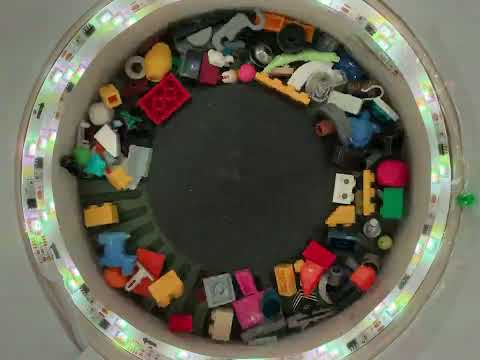

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("NBq8v40ebHE", width=400)

#old movie of a previous revision of the machine, but the priciple is the same

The patches are run through a standard CNN that outputs a l2 normalized feature vector. The goal of the triplet loss is that the feature vector should be similar for images of the same part (anchor to positive), and not similar for images of different parts (anchor to negative).

For each patch in the left image (anchor), the patch with the most similar feature vector in close proximity to the anchor, but in the right image, is our positive example. The most similar, not in proximity, is our negative anchor.


This is a custom adaption of siamese networks with triplet loss learning, as the original is used with labeled examples. The best known usecase for siamese networks are for face recognition, where the model is optimized to provide similar results for different images of the same person.

In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
from huggingface_hub import login
login()


In [5]:
import numpy as np
import cv2
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import DefaultDataCollator

In [7]:

data_collator = DefaultDataCollator(return_tensors="tf")

def convert_to_tf_tensor(image: Image):

    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
       # train_data_augmentation(
          convert_to_tf_tensor(image.convert("RGB")) for image in example_batch["image"]  # )
    ]
    #example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images] #If using Transformer network
    example_batch["pixel_values"] = [tf.squeeze(image) for image in images]
    return example_batch



In [8]:
#load green dataset

ds=load_dataset("Circularmachines/batch_indexing_machine_230614", split="train")
ds.set_transform(preprocess_train)
batch_size=4

tf_ds=ds.to_tf_dataset(columns=["pixel_values"], label_cols="label",  shuffle=False, batch_size=batch_size, collate_fn=data_collator)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/15120 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Circularmachines___parquet/Circularmachines--batch_indexing_machine_230614-86c9793860f0ff04/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


(4, 1088, 1088, 3)


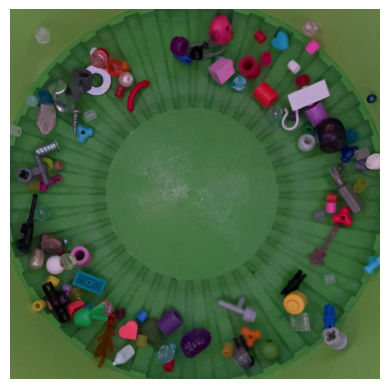

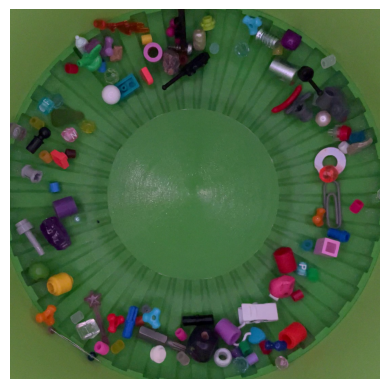

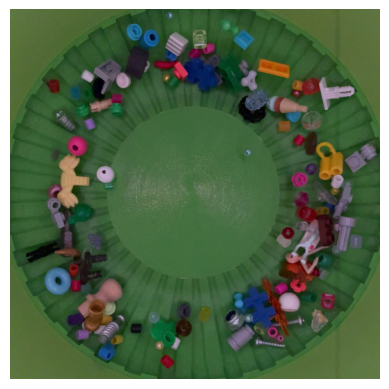

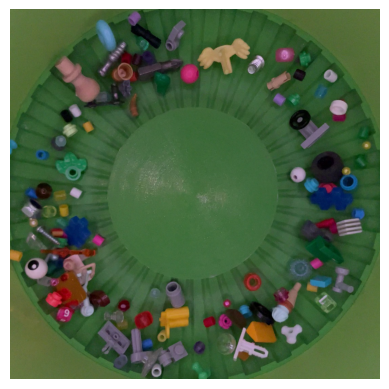

In [11]:
for d in tf_ds.take(1):
  show=d[0]
  print(d[0].shape)

for s in show:
  plt.imshow(s)
  plt.axis('off')
  plt.show()

In [41]:
# Generate the donut shape


image_size=1088
patch_size=68


def donut(patch_size, img_size, lower_limit=0.5, upper_limit=1):

  gridsize=img_size//2//patch_size

  #create a grid of patch coordinates relative to center of image, and calculate distance from center
  coords=np.array([[(i+0.5,j+0.5) for i in range(-gridsize,gridsize)] for j in range(-gridsize,gridsize)])
  norm=np.linalg.norm(coords,axis=2)

  #we are only interested in the "donut" where the parts are, anything close to the center and far from the center is disregarded
  keep_bool=((norm>(gridsize*lower_limit))*(norm<(gridsize*upper_limit)))
  keep=tf.constant(np.where(keep_bool.flatten())[0],dtype=tf.int32)

  return coords,keep,keep_bool

coords,keep,keep_bool=donut(patch_size,image_size)
n_patches=len(keep)
coords_valid=coords.reshape(-1,2)[keep,:]   #the coordinates in the donut relative to center
angle_sort=(-np.arctan2(coords_valid[:,0],coords_valid[:,1])).argsort() #patch indexes reordered by their angle relative to center
angle_sort_inv=np.zeros(len(keep),dtype=int)
angle_sort_inv[angle_sort]=np.arange(len(keep))
print(keep_bool.astype(int))

[[0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0]
 [1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0]]


In [42]:
angle_sort_inv

array([148, 151, 155,   0,   4,   8, 141, 144, 146, 150, 154,   1,   5,
         9,  11,  14, 136, 138, 142, 145, 149, 153,   2,   6,  10,  13,
        17,  18, 131, 134, 137, 139, 143, 147, 152,   3,   7,  12,  16,
        20,  21,  24, 128, 130, 133, 135, 140,  15,  19,  22,  25,  27,
       124, 126, 127, 129, 132,  23,  26,  28,  29,  30, 121, 122, 123,
       125,  31,  32,  33,  34, 117, 118, 119, 120,  35,  36,  37,  38,
       116, 115, 114, 113,  42,  41,  40,  39, 112, 111, 110, 108,  47,
        45,  44,  43, 109, 107, 106, 104, 101,  54,  51,  49,  48,  46,
       105, 103, 100,  97,  93,  62,  59,  55,  52,  50, 102,  99,  98,
        94,  90,  86,  81,  74,  69,  65,  61,  58,  56,  53,  96,  95,
        91,  88,  84,  80,  75,  71,  67,  64,  60,  57,  92,  89,  87,
        83,  79,  76,  72,  68,  66,  63,  85,  82,  78,  77,  73,  70])

In [36]:
keep

<tf.Tensor: shape=(156,), dtype=int32, numpy=
array([  5,   6,   7,   8,   9,  10,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  65,  66,  67,  68,  69,  74,  75,  76,  77,  78,
        80,  81,  82,  83,  84,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 108, 109, 110, 111, 112, 113, 114, 115, 124, 125, 126, 127,
       128, 129, 130, 131, 140, 141, 142, 143, 144, 145, 146, 147, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 171, 172, 173, 174, 175,
       177, 178, 179, 180, 181, 186, 187, 188, 189, 190, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 245, 246, 247, 248, 249, 250],
      dtype=int32)>

In [24]:
#final dataset generation with the patches

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        dim_size = tf.shape(images)[-1]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        #patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [-1,self.patch_size,self.patch_size, dim_size])

        return patches

def patch(x,y):
  patches=Patches(patch_size)(x)
  x=tf.gather(patches,indices=keep)
  x=tf.gather(x,indices=angle_sort)
  return x, tf.repeat(y,keep.shape[0])

def grey(x):
  x=tf.reduce_mean(x,axis=-1,keepdims=True)
  x=tf.cast(x,dtype=tf.uint8)
  x=tf.repeat(x,3,axis=-1)
  return x




ds_train=tf_ds.unbatch().batch(1).map(patch).unbatch().batch(n_patches*2*4,drop_remainder=True)

for d in ds_train.take(1):
  print(d[0].shape)
  batch=d[0]



(1248, 68, 68, 3)


In [25]:
def create_angle_mask(n,fr,to):

  out=np.zeros((n,n),dtype=int)

  for i in range(n):
    out[i,[x%n for x in range(i+fr,i+to)]]=1

  out=np.concatenate([out-1,2*out-1],axis=1)

  out2=np.zeros((n,n),dtype=int)

  for i in range(n):
    out2[i,[x%n for x in range(i-to+1,i-fr+1)]]=1

  out2=np.concatenate([2*out2-1,out2-1],axis=1)

  return np.concatenate([out,out2])

mask=create_angle_mask(n_patches,28,60)[np.newaxis,:,:]

mask=tf.constant(mask,dtype=tf.float32)

mask.shape

TensorShape([1, 312, 312])

In [26]:
def show_patches(p):
  fig = plt.figure(figsize=(8, 8))
  columns = 8
  rows = 8

  for i in range(len(p)):
      img=p[i]
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(img)
      plt.axis('off')

  plt.show()

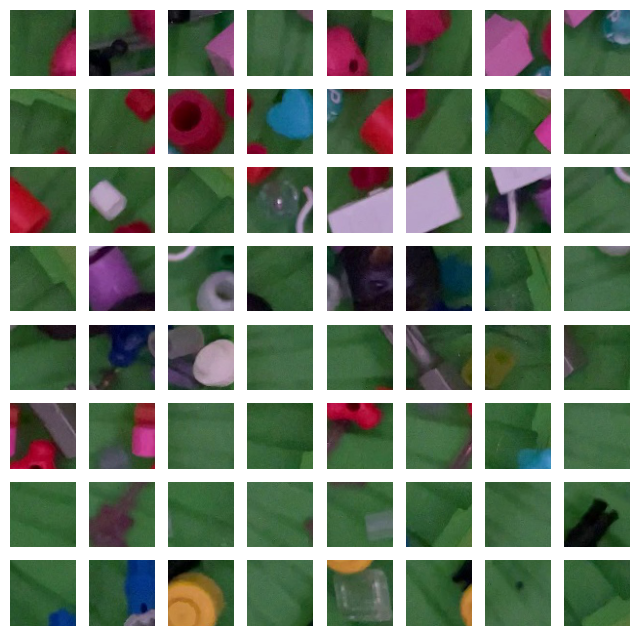

In [27]:
show_patches(batch[0:64])

target:


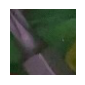

target not visible:


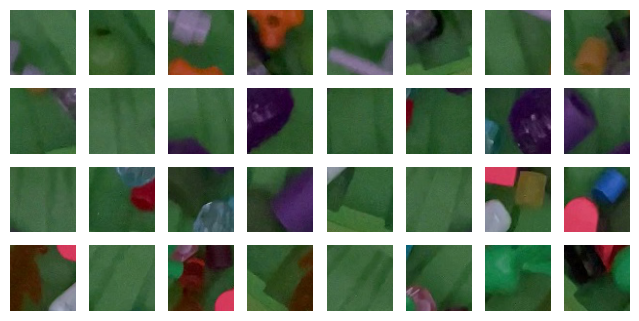

target visible:


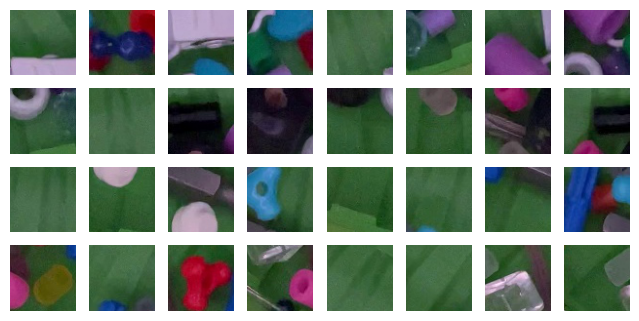

In [29]:
r=37

mask_s=np.squeeze(mask)
batch=batch[:len(mask_s)]

print('target:')
show_patches([batch[r]])
print('target not visible:')
show_patches(batch[mask_s[r]==0])
print('target visible:')
show_patches(batch[mask_s[r]==1])

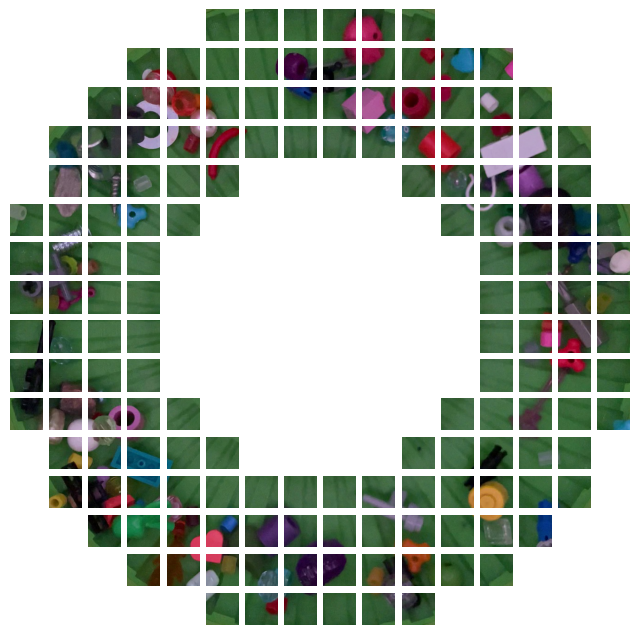

In [43]:
def show_donut(p):
  g=image_size//patch_size
  fig = plt.figure(figsize=(8, 8))
  columns = g
  rows = g

  j=0
  for i in range(g*g):
    if i in keep:
      img=p[angle_sort_inv[j]]
      j+=1
    else:
      img=np.ones((patch_size,patch_size,3))

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')



  plt.show()

show_donut(batch[0:n_patches])

In [ ]:


# the custom loss algorithm!

def custom_triple_loss(y_true,y_pred):




  y_pred=tf.cast(y_pred,mask.dtype)

  a=tf.expand_dims(y_pred,axis=1)
  b=tf.expand_dims(y_pred,axis=2)
  #distance=tf.linalg.norm(a-b,axis=-1)
  distance=tf.reduce_sum(tf.square(a-b),axis=-1)
  distance=tf.sqrt(distance) #contrastive



  maskvalid=tf.cast(tf.equal(mask,-1),mask.dtype)

  distance=distance+maskvalid*1000
#  tf.print(distance)
  mask0=tf.cast(tf.equal(mask,0),mask.dtype)
  min0=tf.reduce_min(distance + (1-mask0)*1000,axis=2)
  mask1=tf.cast(tf.equal(mask,1),mask.dtype)
  min1=tf.reduce_min(distance + (1-mask1)*1000,axis=2)

  valid_min0=tf.cast(tf.not_equal(min0,0),min0.dtype)
  valid_min1=tf.cast(tf.not_equal(min1,0),min1.dtype)
 # tf.print(min0)
 # tf.print(min1)
  margin=0.5
  return  tf.reduce_mean(valid_min1*tf.math.square(min1) + valid_min0*tf.math.square(tf.math.maximum(margin - min0, 0.0))) #contrastive
  #return tf.reduce_mean(tf.maximum(0.0, min1 - min0 + margin)) #triple





custom_triple_loss(0,np.random.random((4,2*n_patches,64)))
#custom_triple_loss(0,np.ones((4,2*n_patches,64)))



<tf.Tensor: shape=(), dtype=float32, numpy=7.7748513>

In [ ]:
img_size=patch_size

inp=tf.keras.Input((img_size,img_size,3),name="main_input")

cnn=tf.keras.applications.EfficientNetV2S(weights=None, include_top=False,input_shape=(img_size,img_size,3),pooling='avg')(inp)

#dropout=tf.keras.layers.Dropout(0.1)(cnn)

dense_layer=tf.keras.layers.Dense(64,activation=None)(cnn)

l2norm=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_layer) #normalize featurevector along 1st axis, needed for the loss function to work (I think)

reshape=tf.keras.layers.Lambda(lambda x: tf.reshape(x,(-1,n_patches*2,64)))(l2norm)

model=tf.keras.Model(inp,reshape)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 68, 68, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 lambda (Lambda)             (None, 64)                0         
                                                                 
 lambda_1 (Lambda)           (None, 312, 64)           0         
                                                                 
Total params: 20,413,344
Trainable params: 20,259,472
Non-trainable params: 153,872
___________________________________________

In [ ]:
model.compile(loss=custom_triple_loss, optimizer="adam")


In [ ]:
model.fit(ds_train,epochs=5)

Epoch 1/5
1890/1890 [==============================] - 1481s 730ms/step - loss: 0.1174
Epoch 2/5
1890/1890 [==============================] - 1385s 733ms/step - loss: 0.1069
Epoch 3/5
1890/1890 [==============================] - 1383s 732ms/step - loss: 0.1026
Epoch 4/5
1890/1890 [==============================] - 1386s 733ms/step - loss: 0.0988
Epoch 5/5
1890/1890 [==============================] - 1379s 730ms/step - loss: 0.0951


In [ ]:
model.optimizer.learning_rate=0.0005

In [ ]:
model.fit(ds_train,epochs=2)

Epoch 1/2
1890/1890 [==============================] - 1377s 728ms/step - loss: 0.0905
Epoch 2/2
1890/1890 [==============================] - 1379s 730ms/step - loss: 0.0890


In [ ]:
model.save_weights('weights.h5')

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj='/content/weights.h5',
    path_in_repo="weights_green_scratch.h5",
    repo_id="Circularmachines/batch_indexing_machine_64x64_triple_loss",
    repo_type="model",
)

#Create Testset database


In [ ]:
img_size=patch_size

inp=tf.keras.Input((img_size,img_size,3),name="main_input")#, batch_size=n_patches*8)

cnn=tf.keras.applications.EfficientNetV2S(include_top=False,input_shape=(img_size,img_size,3),pooling='avg')(inp)

dense_layer=tf.keras.layers.Dense(64,activation=None)(cnn)

l2norm=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_layer) #normalize featurevector along 1st axis, needed for the loss function to work (I think)

#reshape=tf.keras.layers.Lambda(lambda x: tf.reshape(x,(-1,n_patches*2,64)))(l2norm)

model=tf.keras.Model(inp,l2norm)

model.summary()

82420632/82420632 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 68, 68, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                81984     
                                                                 
 lambda_2 (Lambda)           (None, 64)                0         
                                                                 
Total params: 20,413,344
Trainable params: 20,259,472
Non-trainable params: 153,872
_________________________________________________________________


In [ ]:
model.load_weights('weights.h5')

In [ ]:
from datasets import load_dataset

ds_test=load_dataset("Circularmachines/batch_indexing_machine_green_test",split="test")

In [ ]:


class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        dim_size = tf.shape(images)[-1]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size//2, self.patch_size//2, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        #patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [-1,self.patch_size,self.patch_size, dim_size])

        return patches

In [ ]:
#when creating the test set predictions, i do inference on all patches, even if they are outside of the donut and don't contain any parts.

def basic_patch(x):
  x=Patches(patch_size)(x)
  return x


In [ ]:
ds=tf.data.Dataset.from_tensor_slices(np.array([np.array(d['image']) for d in ds_test])).batch(1).map(basic_patch).unbatch().batch(n_patches*4)
pred=model.predict(ds)
pred.shape

647/647 [==============================] - 31s 41ms/step


(403620, 64)

In [ ]:
import pandas as pd

pred_df=pd.DataFrame(np.array(pred).reshape(-1,64))
pred_df.to_csv('test.csv')

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj='test.csv',
    path_in_repo="test_scratch.csv",
    repo_id="Circularmachines/Batch_indexing_machine_pred_csv",
    repo_type="dataset",
)

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:

from huggingface_hub import hf_hub_download
# Download from a dataset
file_name=hf_hub_download(repo_id="Circularmachines/batch_indexing_machine_64x64_triple_loss", filename="weights_green_2.h5")#, repo_type="dataset")
file_name

'/root/.cache/huggingface/hub/models--Circularmachines--batch_indexing_machine_64x64_triple_loss/snapshots/4c4ed7fdba3f0ba84e0f7b1de469fc299962e769/weights_green_2.h5'

In [ ]:
model.load_weights(file_name)